![Py4Eng](img/logo.png)

# Recurrent Neural Networks
## Yoav Ram

In this session we will understand:
- what recurrent neural network and how they work, and
- how memory and state can be implemented in neural networks

This session uses Keras.
You can also view a [NumPy implementation](RNN_np.ipynb), including code for feed forward and back propagation,

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from random import uniform

import keras
print('Keras', keras.__version__)
from keras import backend as K
print('GPU:', K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


Keras 2.2.4
GPU: []


In developing this RNN we will follow [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/)'s [blogpost about RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness) ([original code gist](https://gist.github.com/karpathy/d4dee566867f8291f086) with BSD License).

The data is just text data, in this case Shakespear's writing.

In [2]:
filename = '../data/shakespear.txt'
text = open(filename, 'rt').read()
print("Number of characters: {}".format(len(text)))
print("Number of unique characters: {}".format(len(set(text))))
print("Number of lines: {}".format(text.count('\n')))
print("Number of words: {}".format(text.count(' ')))
print()
print("Excerpt:")
print("*" * len("Excerpt:"))
print(text[:500])

Number of characters: 99993
Number of unique characters: 62
Number of lines: 3298
Number of words: 15893

Excerpt:
********
That, poor contempt, or claim'd thou slept so faithful,
I may contrive our father; and, in their defeated queen,
Her flesh broke me and puttance of expedition house,
And in that same that ever I lament this stomach,
And he, nor Butly and my fury, knowing everything
Grew daily ever, his great strength and thought
The bright buds of mine own.

BIONDELLO:
Marry, that it may not pray their patience.'

KING LEAR:
The instant common maid, as we may less be
a brave gentleman and joiner: he that finds u


# Preparations

We start by creating 
- a list `chars` of the unique characters
- `data_size` the number of total characters
- `vocab_size` the number of unique characters
- `idx_to_char` a dictionary from index to char
- `char_to_idx` a dictionary from char to index
and then we convert `data` from a string to a NumPy array integers representing the chars via their indexes.

In [3]:
chars = list(set(text))
data_size, vocab_size = len(text), len(chars)

id_to_char = dict(enumerate(chars)) # { i: ch for i,ch in enumerate(chars) }
char_to_id = dict(zip(id_to_char.values(), id_to_char.keys())) # { ch: i for i,ch in enumerate(chars) }
data = np.array([char_to_id[c] for c in text], dtype=int)

We segment the text to semi-redundant (i.e. overlapping) sequences of `seq_length` characters.

In [4]:
seq_length = 40
step = 3
sequences = []
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sequences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
n_sequences = len(sequences)
print('# sequences:', n_sequences)
print(sequences[0], '->', next_chars[0])

# sequences: 33318
That, poor contempt, or claim'd thou sle -> p


We now convert the strings data to numerical data using one-hot encoding.

Shapes:
- `X` is `(n_sequences, seq_length, vocab_size)`
- `Y` is `(n_sequences, vocab_size)`

In [5]:
X = np.zeros((n_sequences, seq_length, vocab_size), dtype=np.bool)
Y = np.zeros((n_sequences, vocab_size), dtype=np.bool)

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_id[char]] = 1
    Y[i, char_to_id[next_chars[i]]] = 1

# RNN model

- $x(t)$ is the $t$ character, one-hot encoded and a 1D array of length `vocab_size`.
- $h(t)$ is the state of the hidden memory layer after seeing $t$ characters, encoded as a 1D array of numbers (neurons...)
- $\widehat y(t)$ is the prediction of the network after seeing $t$ characters, encoded as a 1D array of probabilities of length `vocab_size`

The model is then written as:

$$
h(t) = \tanh{\big(x(t) \cdot W_x^h + h(t-1) \cdot W_h^h + b_h\big)} \\
\widehat y(t) = softmax\big(h(t) \cdot W_h^y\big)
$$

and we set $h(0) = (0, \ldots, 0)$.

# Back propagation and "unrolling" the network

Back propagation works, as before, using the chain rule. 
It is similar to the [FFN example](FFN.ipynb), except that the $h$ layer adds a bit of complexity, but not much.

The details of the gradient calculation can be found in Stanford's ["Convolutional Neural Networks for Visual Recognition" course](http://cs231n.github.io/neural-networks-case-study/#grad).

What's important to discuss is that instead of back propagating a single step of the network $t$, we back propagate over a sequence of steps, that is over $x=(x_1, \ldots, x_k)$ for some arbitrary $k$.

![rolled RNN](img/rolled_rnn.png)

How? By "unrolling" the network.

![Unrolled RNN](img/unrolled_rnn.png)

For example, for $k=3$, the input is $x=[x(1), x(2), x(3)]$, and we can write

$$
h(1) = \tanh{\big(x(1) \cdot W_x^h + h(0) \cdot W_h^h + b_h\big)} \\
\widehat y(1) = softmax\big(h(1) \cdot W_h^y\big) \\
h(2) = \tanh{\big(x(2) \cdot W_x^h + h(1) \cdot W_h^h + b_h\big)} \\
\widehat y(2) = softmax\big(h(2) \cdot W_h^y\big) \\
h(3) = \tanh{\big(x(3) \cdot W_x^h + h(2) \cdot W_h^h + b_h\big)} \\
\widehat y(3) = softmax\big(h(3) \cdot W_h^y\big)
$$

The loss is computed by summing over all $\widehat y(t)$ together, and then the gradient is computed for this loss with respect to the various $W$ and $b$ parameters.

# Sampling from the network

Finally, to sample from the network, we need the parameters $W$s and $b$s, a seed char, and a state for the hidden layer.
We can then produce a sample of text from the network.

It does so by using the seed as $x(1)$ and drawing $x(t)$ for $t>1$ from the distribution given by $\widehat y(t)$.

![](img/sampling_rnn.png)

In [24]:
def example(epoch, *args):
    if epoch % 10 != 0: return
    # get random sequence from text
    start = np.random.randint(0, data_size - seq_length - 1)
    seq = text[start:start + seq_length]
    # one-hot encode
    x = np.zeros((1, seq_length, vocab_size), dtype=float)
    for t, char in enumerate(seq):
        x[0, t, char_to_id[char]] = 1
    print(f'----- Generating text after Epoch {epoch} with seed: {seq}')
    
    for i in range(300):
        # predict char distribution
        pred = model.predict(x).squeeze() # returns 2D array
        # sample char
        char_id = np.random.multinomial(1, pred).argmax()
        next_char = id_to_char[char_id]
        print(next_char, end='')
        
        # update x
        x[0, :-1, :] = x[0, 1:, :]
        x[0, -1, 0] = 0
        x[0, -1, char_id] = 1
        
    print('', flush=True) # flush makes sure that print doenst wait for buffer to be full

# Building the model

In [21]:
h_size = 128 # number of units in hidden layer

layers = [
    keras.layers.SimpleRNN(h_size, input_shape=(None, vocab_size)), # None let's us use variable sequence length; in the same batch we must have the same shape, though
    keras.layers.Dense(vocab_size, activation='softmax')
    
]
model = keras.models.Sequential(layers)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128)               24448     
_________________________________________________________________
dense_4 (Dense)              (None, 62)                7998      
Total params: 32,446
Trainable params: 32,446
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=[keras.metrics.categorical_accuracy])

# Training the network


On my laptop, a single epoch takes 4-5 seconds.

In [23]:
history = model.fit(X, Y, 
          batch_size=128, 
          epochs=100,
          validation_split=0.1, 
          callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=example)]).history

Train on 29986 samples, validate on 3332 samples
Epoch 1/1
29986/29986 [==============================] - 10s 333us/step - loss: 3.1133 - categorical_accuracy: 0.2025 - val_loss: 2.7937 - val_categorical_accuracy: 0.2725
----- Generating text after Epoch 0 with seed: on, we are for death:
Marry, there was f
nrrX  nmtl hh-de, e  o 
ii.   r ,  s    rrf       e l   
  c u r  ua  .ay n r lc ev   rcar ,h,    tr       ar n d s  ,      t ma     e      ,   cg l ea   g     , d  ,  
  oa e      
      r,  o ,   a h h     d sr
   
      '  sr dl,      , Ba,orr
 
   
  w    s   d    a, e 
   l     ,, l  a ees
 r  


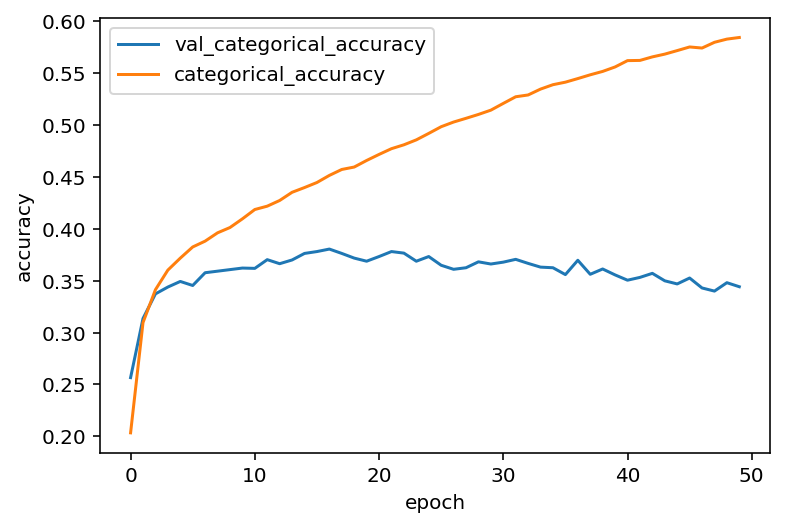

In [35]:
for k, v in history.items():
    if 'acc' in k:
        plt.plot(v, label=k)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

# References

- [NumPy implementation](RNN_np.ipynb) of this same task.
- TensorFlow [RNN tutorial](https://www.tensorflow.org/tutorials/recurrent)
- Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) blogpost
- [Obama-RNN](https://medium.com/@samim/obama-rnn-machine-generated-political-speeches-c8abd18a2ea0) by samim.
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization) on Stanford's "Unsupervised Feature Learning and Deep Learning" tutorial
- [Making a Predictive Keyboard using Recurrent Neural Networks](http://curiousily.com/data-science/2017/05/23/tensorflow-for-hackers-part-5.html) by Venelin Valkov

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://github.com/yoavram/DataSciPy) workshop.

The notebook was written using [Python](http://python.org/) 3.6.5.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)